# Train the contender on self-play episodes of the champion

## TODO: Consolidate with other notebooks

In [7]:
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np

from aegomoku.gomoku_board import GomokuBoard
from aegomoku.gomoku_game import GomokuGame as Gomoku
from aegomoku.gomoku_model import NeuralNetAdapter
from aegomoku.interfaces import MctsParams
from aegomoku.mcts import MCTS
from aegomoku.utils import analyse_board
import aegomoku.tools as gt
from aegomoku.policies.heuristic_policy import HeuristicPolicy

In [21]:
BOARD_SIZE = 15

## The initial board
The initial board features 4 stones randomly positioned on the inner 5x5 sector.

That allows for very different, although sometimes unrealistic game situations.

In [22]:
from aegomoku.gomoku_game import RandomBoardInitializer

game = Gomoku(BOARD_SIZE, initializer=RandomBoardInitializer(BOARD_SIZE, 4, 5, 9, 5, 9))

----

## Heuristic plus MCTS
With the heuristic policy, the search tree produces very reasonable trajectories, even with a small number of simulations.

Note that we only show the general concept here. Due to the bad performance of the self-play in a single-threaded environment, we'll use a parallel computing setup using *ray* to produce trajectories more efficiently.

In [23]:
policy = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
mcts_params = MctsParams(cpuct=1.0, num_simulations=100, advice_cutoff=.4)
mcts = MCTS(game, policy, mcts_params)

/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [47]:
board = game.get_initial_board()  # random start positions, sometimes unfair, but so what?
print(board)

# Two mood versions of the champion playing against each other = less draws
# These settings may change over the training period, once opponents get stronger.
temperatures = [0.6, 0]  # more tight vs more explorative

episode_step = 0
train_examples = []
done = policy.get_winner(board.canonical_representation())
while done is None:
    episode_step += 1
    t = temperatures[episode_step % 2]
    pi = mcts.get_action_prob(board, temperature=t)
    action = np.random.choice(len(pi), p=pi)
    board.act(action)
    print(board)
    done = policy.get_winner(board.canonical_representation())

# The player who made the last move, is the winner.
print (f"The winner is {1-board.get_current_player()}")
board.plot()

J9 G10 F6 F8 (Black next)
J9 G10 F6 F8 F10 (White next)
J9 G10 F6 F8 F10 K11 (Black next)
J9 G10 F6 F8 F10 K11 F5 (White next)
J9 G10 F6 F8 F10 K11 F5 F3 (Black next)
... G10 F6 F8 F10 K11 F5 F3 G5 (White next)
... F6 F8 F10 K11 F5 F3 G5 D5 (Black next)
... F8 F10 K11 F5 F3 G5 D5 I5 (White next)
... F10 K11 F5 F3 G5 D5 I5 H5 (Black next)
... K11 F5 F3 G5 D5 I5 H5 H4 (White next)
... F5 F3 G5 D5 I5 H5 H4 I3 (Black next)
... F3 G5 D5 I5 H5 H4 I3 G3 (White next)
... G5 D5 I5 H5 H4 I3 G3 F2 (Black next)
... D5 I5 H5 H4 I3 G3 F2 G4 (White next)
... I5 H5 H4 I3 G3 F2 G4 G6 (Black next)
... H5 H4 I3 G3 F2 G4 G6 I4 (White next)
... H4 I3 G3 F2 G4 G6 I4 F4 (Black next)
... I3 G3 F2 G4 G6 I4 F4 G2 (White next)
... G3 F2 G4 G6 I4 F4 G2 G1 (Black next)
... F2 G4 G6 I4 F4 G2 G1 H3 (White next)
... G4 G6 I4 F4 G2 G1 H3 J5 (Black next)
... G6 I4 F4 G2 G1 H3 J5 E6 (White next)
... I4 F4 G2 G1 H3 J5 E6 I2 (Black next)
... F4 G2 G1 H3 J5 E6 I2 D7 (White next)
The winner is 0
                            

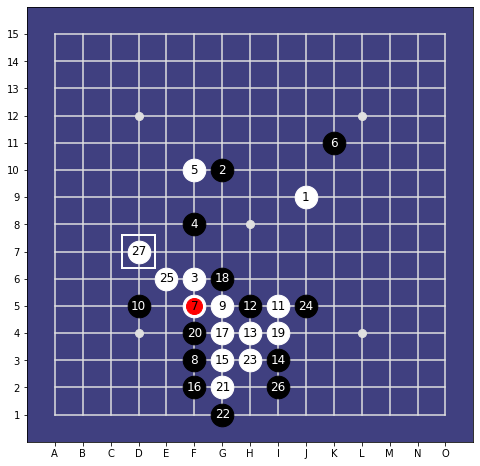

In [48]:
stones = board.stones
analyse_board(BOARD_SIZE, stones, policy)

### A couple of steps earlier
The policy's opinion about that board state looked still undecided

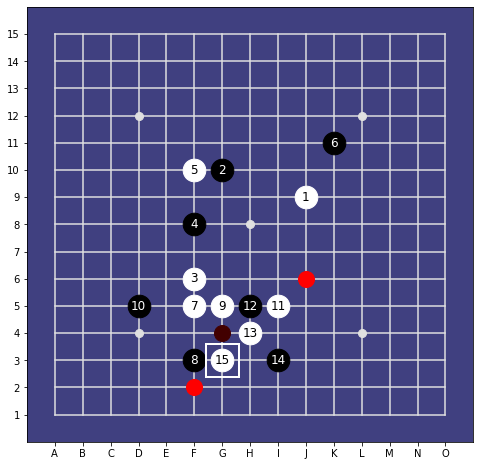

In [49]:
stones = board.stones[:-12]
analyse_board(BOARD_SIZE, stones, policy)

---

In [50]:
board = GomokuBoard(BOARD_SIZE, stones)
pi, v = policy(board.canonical_representation())
print((np.array(pi)*1000).astype(int))
print(f"Value: {v}")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   7   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   7   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  15   0   0   7   0   0   8   8   0   0   0   0]
 [  0   0   7   8   8   0   0   0   0   8   0   0   0   0   0]
 [  0   0  24   7   8   0  17   8  33 282   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  49   8  66   0   8   8   0   0   0   0   0]
 [  0   0   0   7   0   0   0   8   0   0   0   0   0   0   0]
 [  0   0   0   0  24 281  41   0   7   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
Value: -0.12238275801809427


---

### The search tree has a similar yet more ascertive opinion
That's because the MCTS has reasoned on those positions by following the initial recommendations for a couple of steps.
The action counts will inform the next policy and the $max(Q_a)$ may inform the value function.

In most cases, the softmax will agree with the move actually taken, only if the chances are somewhat equally distributed, will the softmax also allow for a choice.

In [51]:
key = board.get_string_representation()
probs = mcts.compute_probs(board, temperature=1.0)
probs = np.array(probs).reshape([BOARD_SIZE, BOARD_SIZE])
print((probs*100).astype(int))
q_advice = [mcts.Q.get((key, i), -float('inf')) for i in range(225)]
print()
print(f"Value from max(Q): {np.max(q_advice)}")

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 43  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 52  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]

Value from max(Q): -0.09032866360465279


# Symmetries
The board, together with the resulting probabilities can be rotated or flipped to produce just another valid training example. In total, we 8-fold our training data.

In [55]:
math_rep = board.canonical_representation()
symmetries = game.get_symmetries(math_rep, probs)
symmetries[0][0].shape

(17, 17, 3)

We see the board diagonally flipped

In [56]:
gt.print_channels(symmetries[0][0])

shape: (17, 17, 3)
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3]
 [3 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 2 0 2 0 0 0 0 1 0 0 0 0 0 3]
 [3 0 0 1 0 2 2 0 1 0 2 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [57]:
for i in range(1):
    print((np.array(symmetries[i][1]).reshape(15, 15) * 100).astype(int))
    print()

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 43  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 52  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]



---

# Training

Would be nice to see the training converge (and overfit) with a single episode in its 8 symmetries, and validate the overfitted against a board with all stones shifted. We'd expect only minor differences due to the different border influence, but otherwise the conv-only network naturally features translation symmetry.

Note that this you'd need have this run with GPU power to get reasonable results

In [62]:
examples_file = 'temperature/checkpoint_0.pth.tar.examples'

In [63]:
from pickle import Unpickler

with open(examples_file, "rb") as f:
    examples = Unpickler(f).load()


In [67]:
len(examples[0]), examples[0][0][0].shape

(136, (17, 17, 3))

In [72]:
the_model = NeuralNetAdapter( BOARD_SIZE+ 2)
the_model.policy.summary()
sample = np.expand_dims(examples[0][0][0], axis=0).astype(float)
print(sample.shape)
the_model.policy(sample, debug=True)

Model: "gomoku_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 initial (Conv2D)            multiple                  11648     
                                                                 
 potential_0 (Conv2D)        multiple                  123936    
                                                                 
 potential_1 (Conv2D)        multiple                  123936    
                                                                 
 potential_2 (Conv2D)        multiple                  123936    
                                                                 
 potential_3 (Conv2D)        multiple                  123936    
                                                                 
 potential_4 (Conv2D)        multiple                  123936    
                                                                 
 policy_aggregator (Conv2D)  multiple               

(<tf.Tensor: shape=(1, 225), dtype=float32, numpy=
 array([[0.00455799, 0.00509792, 0.00546454, 0.00515628, 0.00473923,
         0.00403266, 0.00346408, 0.00346408, 0.00346408, 0.00346408,
         0.00346408, 0.00424957, 0.00346408, 0.00346408, 0.00346408,
         0.00434055, 0.00464742, 0.00486022, 0.00451771, 0.00415487,
         0.00371868, 0.00355838, 0.00346408, 0.00346408, 0.00346408,
         0.00346408, 0.00346461, 0.00346408, 0.00346408, 0.00346408,
         0.00515405, 0.00586532, 0.00632549, 0.00604665, 0.00457749,
         0.00400578, 0.00386804, 0.00351325, 0.00346408, 0.00346408,
         0.00346408, 0.00346408, 0.00346408, 0.00346408, 0.00346408,
         0.00562472, 0.00639454, 0.00648001, 0.00599687, 0.0051274 ,
         0.00529881, 0.00508934, 0.00444041, 0.00394006, 0.00351003,
         0.00358519, 0.00389106, 0.00346408, 0.00346408, 0.00346408,
         0.00510778, 0.00707745, 0.00655169, 0.00687788, 0.00632183,
         0.0062313 , 0.00540417, 0.00524577, 0.00443

In [88]:
the_model.train(examples[0], epochs_per_train=100)

Epoch: 1, Loss: 4.434621810913086
Epochs: 100, Loss: 3.8916749954223633


In [93]:
ex=examples[0][-27]
print(len(ex), ex[0].shape, ex[2])
print((np.array(ex[1]) * 100).reshape((15, 15)).astype(int))
gt.print_channels(ex[0])

3 (17, 17, 3) -0.9940649207210548
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
shape: (17, 17, 3)
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 1 1 2 0 0 0 0 3]
 [3 

In [94]:
p, v = the_model.predict(np.expand_dims(ex[0], axis=0).astype(float), debug=True)
print((p*100).numpy().reshape((15, 15)).astype(int))
print()
print(f"Value: {v}")

Potential: 100848.2578125
Value Head: -224.99996948242188
Policy Head: 1385.758056640625
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 15  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0 12  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 13  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 28  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]

Value: [[0.06153749]]
